In [1]:
import os
import findspark
findspark.init()
findspark.find()
from pyspark.sql.functions import lit
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import monotonically_increasing_id
import matplotlib.pyplot as plt
import seaborn as sb
from pyspark.sql.types import FloatType,IntegerType

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
# create data folder to store player files
# !hadoop fs -mkdir /data

In [4]:
# !hadoop fs -put players_15.csv players_16.csv players_17.csv players_18.csv players_19.csv players_20.csv players_21.csv players_22.csv /data

In [5]:
# !hadoop fs -put postgresql-42.6.0.jar /

# Task I

In [6]:
# connect spark to PostgreSQL
appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
#
# spark = SparkSession \
#     .builder \
#     .appName("fifa") \
#     .config("spark.jars", "/Users/zhengshaoxuan/Desktop/postgresql-42.6.0.jar") \
#     .config("spark.executor.memory", "4g") \
#     .config("spark.driver.memory", "2g") \
#     .config("spark.executor.instances", "4") \
#     .config("spark.executor.cores", "2") \
#     .getOrCreate()
spark = SparkSession.builder \
    .master("yarn") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.6.0.jar") \
    .appName("SparkMLOct10-RF500-yarn") \
    .getOrCreate()

conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master) 

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context   Mod1: spark creation
# spark = sqlContext.sparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/12 03:26:20 INFO SparkEnv: Registering MapOutputTracker
23/11/12 03:26:20 INFO SparkEnv: Registering BlockManagerMaster
23/11/12 03:26:20 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/12 03:26:20 INFO SparkEnv: Registering OutputCommitCoordinator
/usr/lib/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
#spark DataFrame Schema
#We need both spark schema and postgres schema, because the datatypes of spark and postgresql don't match with each other

#It's very strange for club_team_id and nation_team_id. 
#If I set tem to be int, all the club_team_id and nation_team_id read from the csv file will be null.
#Therefore, I have to set them float
fifa='''
sofifa_id int NOT NULL,
player_url string NOT NULL,
short_name string NOT NULL,
long_name string NOT NULL,
player_positions string NOT NULL,
overall int NOT NULL,
potential int NOT NULL,
value_eur float,
wage_eur float,
age int NOT NULL,
dob date NOT NULL,
height_cm int NOT NULL,
weight_kg int NOT NULL,
club_team_id float, 
club_name string,
league_name string,
league_level int,
club_position string,
club_jersey_number int,
club_loaned_from string,
club_joined date,
club_contract_valid_until int,
nationality_id int NOT NULL,
nationality_name string NOT NULL,
nation_team_id float,
nation_position string,
nation_jersey_number int,
preferred_foot string NOT NULL,
weak_foot int NOT NULL,
skill_moves int NOT NULL,
international_reputation int NOT NULL,
work_rate string,body_type string NOT NULL,
real_face string NOT NULL,
release_clause_eur float,
player_tags string,
player_traits string,
pace int,shooting int,
passing int,dribbling int,
defending int,physic int,
attacking_crossing int NOT NULL,
attacking_finishing int NOT NULL,
attacking_heading_accuracy int NOT NULL,
attacking_short_passing int NOT NULL,
attacking_volleys int NOT NULL,
skill_dribbling int NOT NULL,
skill_curve int NOT NULL,
skill_fk_accuracy int NOT NULL,
skill_long_passing int NOT NULL,
skill_ball_control int NOT NULL,
movement_acceleration int NOT NULL,
movement_sprint_speed int NOT NULL,
movement_agility int NOT NULL,
movement_reactions int NOT NULL,
movement_balance int NOT NULL,
power_shot_power int NOT NULL,
power_jumping int NOT NULL,
power_stamina int NOT NULL,
power_strength int NOT NULL,
power_long_shots int NOT NULL,
mentality_aggression int NOT NULL,
mentality_interceptions int NOT NULL,
mentality_positioning int NOT NULL,
mentality_vision int NOT NULL,
mentality_penalties int NOT NULL,
mentality_composure int,
defending_marking_awareness int NOT NULL,
defending_standing_tackle int NOT NULL,
defending_sliding_tackle int NOT NULL,
goalkeeping_diving int NOT NULL,
goalkeeping_handling int NOT NULL,
goalkeeping_kicking int NOT NULL,
goalkeeping_positioning int NOT NULL,
goalkeeping_reflexes int NOT NULL,
goalkeeping_speed int,
ls string NOT NULL,
st string NOT NULL,
rs string NOT NULL,
lw string NOT NULL,
lf string NOT NULL,
cf string NOT NULL,
rf string NOT NULL,
rw string NOT NULL,
lam string NOT NULL,
cam string NOT NULL,
ram string NOT NULL,
lm string NOT NULL,
lcm string NOT NULL,
cm string NOT NULL,
rcm string NOT NULL,
rm string NOT NULL,
lwb string NOT NULL,
ldm string NOT NULL,
cdm string NOT NULL,
rdm string NOT NULL,
rwb string NOT NULL,
lb string NOT NULL,
lcb string NOT NULL,
cb string NOT NULL,
rcb string NOT NULL,
rb string NOT NULL,
gk string NOT NULL,
player_face_url string NOT NULL,
club_logo_url string,
club_flag_url string,
nation_logo_url string NOT NULL,
nation_flag_url string NOT NULL
'''

In [8]:
df = spark.read.csv("/data/players_15.csv",header=True,schema=fifa)

In [9]:
df.show(1,vertical=True)

23/11/12 03:21:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24           
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [10]:
df.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: float (nullable = true)
 |-- wage_eur: float (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: float (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |--

In [11]:
# import datetime
# schema = "dob date"
# data = [ [datetime.datetime.strptime('2021-01-01', "%Y-%m-%d").date()],
#         [datetime.datetime.strptime('2000-01-01', "%Y-%m-%d").date()]]

# test_df = spark.createDataFrame(data, schema)

In [12]:
df=df.withColumn("year",lit(2015))

In [13]:
df.show(1,vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24           
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [14]:
df.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: float (nullable = true)
 |-- wage_eur: float (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: float (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: date (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |--

In [15]:
#don't consider players_15,because we will use union
# players_list=os.listdir("./data")[10:]
players_list = ['players_22.csv',
 'players_21.csv',
 'players_20.csv',
 'players_18.csv',
 'players_19.csv',
 'players_17.csv',
 'players_16.csv']

In [16]:
# print(os.path.join("./data/",players_list[0]).split('_')[1][:2])
# print(2000+int(os.path.join("./data/",players_list[0]).split('_')[1][:2]))

In [17]:
for i in players_list:
    path=os.path.join("/data/",i)
    temp_df=spark.read.csv(path,header=True,schema=fifa)
    year=2000+int(path.split('_')[1][:2])
    temp_df=temp_df.withColumn("year",lit(year))
    df = df.union(temp_df)

In [18]:
df.count()

142079

## Since the data is too much, it took hours to run some of the code below, based on piazza https://piazza.com/class/lljmn5i5nw45fi/post/264, we take half of data

In [19]:
df = df.sample(fraction=0.1, seed=42)
df.count()

14134

In [20]:
df.select("year").distinct().show()

+----+
|year|
+----+
|2015|
|2022|
|2021|
|2020|
|2018|
|2019|
|2017|
|2016|
+----+



In [21]:
#142079 !=45629,so sofifa_id can't be used as unique id
df.select("sofifa_id").distinct().count()

11895

In [22]:
# df.write.mode("overwrite").saveAsTable("fifa")
# spark.catalog.listTables()

In [23]:
# df=df.withColumn("id",monotonically_increasing_id())
# df.printSchema()

In [24]:
# #cast club_team_id,nation_team_id into "integer"
# df=df.withColumn("new_club_team_id",df["club_team_id"].cast("integer")).drop("club_team_id").withColumnRenamed("new_club_team_id","club_team_id")
# df=df.withColumn("new_nation_team_id",df["nation_team_id"].cast("integer")).drop("nation_team_id").withColumnRenamed("new_nation_team_id","nation_team_id")

In [25]:
#in order to check "NOT NULL"
from pyspark.sql.functions import *

null_counts_plays_df = df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns])

null_counts_plays_df.show(truncate=False, vertical=True)

-RECORD 0----------------------------
 sofifa_id                   | 0     
 player_url                  | 0     
 short_name                  | 0     
 long_name                   | 0     
 player_positions            | 0     
 overall                     | 0     
 potential                   | 0     
 value_eur                   | 191   
 wage_eur                    | 159   
 age                         | 0     
 dob                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 club_team_id                | 159   
 club_name                   | 159   
 league_name                 | 159   
 league_level                | 193   
 club_position               | 159   
 club_jersey_number          | 159   
 club_loaned_from            | 13304 
 club_joined                 | 989   
 club_contract_valid_until   | 159   
 nationality_id              | 0     
 nationality_name            | 0     
 nation_team_id              | 13271 
 nation_posi

In [26]:
#Before overwriting data, we had better create the table first
#so that we can define table datatypes instead of automatic inference.
#We have to know that there isn't a match between spark datatypes and postgresql datatypes

# !pip install psycopg2
import psycopg2
from psycopg2 import sql

conn = psycopg2.connect(
    dbname="quickstart-db",
    user="quickstart-user",
    password="toolChain",
    host="10.59.80.3",
    port="5432"
)

cur = conn.cursor()

In [27]:
#check if we have already created the table first
check_table_query = sql.SQL("""
    SELECT EXISTS (
        SELECT 1
        FROM information_schema.tables
        WHERE table_name = 'fifa'
    )
""")
cur.execute(check_table_query)
table_exists = cur.fetchone()[0]

try:
    cur.execute(check_table_query)
    table_exists = cur.fetchone()[0]
    print("Table fifa exist:{}".format(table_exists))
    if table_exists:
        drop_table_query="""
            drop table fifa;
        """
        cur.execute(drop_table_query)
        conn.commit()
        print("Successfully drop table fifa")
        #postgresql schema
        #use (year,sofifa_id) as our primary key
    create_table_query = """
    CREATE TABLE fifa (
        sofifa_id INT NOT NULL,
        player_url VARCHAR(255) UNIQUE NOT NULL,
        short_name VARCHAR(64) NOT NULL,
        long_name VARCHAR(255) NOT NULL,
        player_positions VARCHAR(64) NOT NULL,
        overall INT NOT NULL,
        potential INT NOT NULL,
        value_eur FLOAT,
        wage_eur FLOAT,
        age INT NOT NULL,
        dob DATE NOT NULL,
        height_cm INT NOT NULL,
        weight_kg INT NOT NULL,
        club_team_id FLOAT, 
        club_name VARCHAR(255),
        league_name VARCHAR(255),
        league_level INT,
        club_position VARCHAR(255),
        club_jersey_number INT,
        club_loaned_from VARCHAR(255),
        club_joined DATE,
        club_contract_valid_until INT,
        nationality_id INT NOT NULL,
        nationality_name VARCHAR(255) NOT NULL,
        nation_team_id FLOAT,
        nation_position VARCHAR(255),
        nation_jersey_number INT,
        preferred_foot VARCHAR(255) NOT NULL,
        weak_foot INT NOT NULL,
        skill_moves INT NOT NULL,
        international_reputation INT NOT NULL,
        work_rate VARCHAR(255) NOT NULL,
        body_type VARCHAR(255) NOT NULL,
        real_face VARCHAR(255) NOT NULL,
        release_clause_eur VARCHAR(255),
        player_tags VARCHAR(255),
        player_traits VARCHAR(255),
        pace INT,
        shooting INT,
        passing INT,
        dribbling INT,
        defending INT,
        physic INT,
        attacking_crossing INT NOT NULL,
        attacking_finishing INT NOT NULL,
        attacking_heading_accuracy INT NOT NULL,
        attacking_short_passing INT NOT NULL,
        attacking_volleys INT NOT NULL,
        skill_dribbling INT NOT NULL,
        skill_curve INT NOT NULL,
        skill_fk_accuracy INT NOT NULL,
        skill_long_passing INT NOT NULL,
        skill_ball_control INT NOT NULL,
        movement_acceleration INT NOT NULL,
        movement_sprint_speed INT NOT NULL,
        movement_agility INT NOT NULL,
        movement_reactions INT NOT NULL,
        movement_balance INT NOT NULL,
        power_shot_power INT NOT NULL,
        power_jumping INT NOT NULL,
        power_stamina INT NOT NULL,
        power_strength INT NOT NULL,
        power_long_shots INT NOT NULL,
        mentality_aggression INT NOT NULL,
        mentality_interceptions INT NOT NULL,
        mentality_positioning INT NOT NULL,
        mentality_vision INT NOT NULL,
        mentality_penalties INT NOT NULL,
        mentality_composure VARCHAR(255),
        defending_marking_awareness INT NOT NULL,
        defending_standing_tackle INT NOT NULL,
        defending_sliding_tackle INT NOT NULL,
        goalkeeping_diving INT NOT NULL,
        goalkeeping_handling INT NOT NULL,
        goalkeeping_kicking INT NOT NULL,
        goalkeeping_positioning INT NOT NULL,
        goalkeeping_reflexes INT NOT NULL,
        goalkeeping_speed INT,
        ls VARCHAR(32) NOT NULL,
        st VARCHAR(32) NOT NULL,
        rs VARCHAR(32) NOT NULL,
        lw VARCHAR(32) NOT NULL,
        lf VARCHAR(32) NOT NULL,
        cf VARCHAR(32) NOT NULL,
        rf VARCHAR(32) NOT NULL,
        rw VARCHAR(32) NOT NULL,
        lam VARCHAR(32) NOT NULL,
        cam VARCHAR(32) NOT NULL,
        ram VARCHAR(32) NOT NULL,
        lm VARCHAR(32) NOT NULL,
        lcm VARCHAR(32) NOT NULL,
        cm VARCHAR(32) NOT NULL,
        rcm VARCHAR(32) NOT NULL,
        rm VARCHAR(32) NOT NULL,
        lwb VARCHAR(32) NOT NULL,
        ldm VARCHAR(32) NOT NULL,
        cdm VARCHAR(32) NOT NULL,
        rdm VARCHAR(32) NOT NULL,
        rwb VARCHAR(32) NOT NULL,
        lb VARCHAR(32) NOT NULL,
        lcb VARCHAR(32) NOT NULL,
        cb VARCHAR(32) NOT NULL,
        rcb VARCHAR(32) NOT NULL,
        rb VARCHAR(32) NOT NULL,
        gk VARCHAR(32) NOT NULL,
        player_face_url VARCHAR(32) NOT NULL,
        club_logo_url VARCHAR(255),
        club_flag_url VARCHAR(255),
        nation_logo_url VARCHAR(255),
        nation_flag_url VARCHAR(32) NOT NULL,
        year INT NOT NULL,
        PRIMARY KEY (year,sofifa_id)
    );
    """
    # create table
    cur.execute(create_table_query)
    conn.commit()
    print(f"Table fifa created successfully.")
except psycopg2.Error as e:
    print(f"Error: {e}")
finally:
    cur.close()
    conn.close()

Table fifa exist:True
Successfully drop table fifa
Table fifa created successfully.


In [7]:
db_properties={}
db_properties['username']="quickstart-user"
db_properties['password']="toolChain"
db_properties['url']= "jdbc:postgresql://10.59.80.3:5432/postgres"
db_properties['table']="fifa"
db_properties['driver']="org.postgresql.Driver"

df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

# Task II

## Q1

In [29]:
#when we read data from postgresql, it will automatically transform postgresql datatype into pyspark datatype
#besides, since before overwriting, we have already defined schema as fifa, we will get the same schema as fifa when we read 
#If we didn't define pyspark schema, when we read back, for example, we shall get double variable instead of float
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)
df_read.printSchema()

-RECORD 0-------------------------------------------
 sofifa_id                   | 215128               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Monje             
 long_name                   | Leonardo Monje       
 player_positions            | LW                   
 overall                     | 66                   
 potential                   | 66                   
 value_eur                   | 400000.0             
 wage_eur                    | 2000.0               
 age                         | 33                   
 dob                         | 1981-03-16           
 height_cm                   | 165                  
 weight_kg                   | 65                   
 club_team_id                | 112534.0             
 club_name                   | CD Universidad de... 
 league_name                 | Chilian Campeonat... 
 league_level                | 1                    
 club_position               | SUB            

In [30]:
df_read.createOrReplaceTempView("df_view")
df=df_read

In [31]:
def contracts_ending_2023(x):
    df1=df.filter((col('club_contract_valid_until')==2023) & (col('year')==2022)).groupBy('club_name').\
        agg(count('sofifa_id').alias('number_of_players')).orderBy(col('number_of_players').desc())
    pivot=df1.take(x)[x-1]['number_of_players']
    df1.filter(col('number_of_players')>=pivot).show()

In [32]:
contracts_ending_2023(5)

+--------------------+-----------------+
|           club_name|number_of_players|
+--------------------+-----------------+
|       Coventry City|               10|
|              Al Tai|               10|
| Club Atlético Lanús|                9|
|   FC Erzgebirge Aue|                9|
|          1. FC Köln|                9|
|      Fleetwood Town|                9|
|FC Würzburger Kic...|                9|
|     N.E.C. Nijmegen|                9|
|          CA Osasuna|                9|
|Sepsi OSK Sf. Ghe...|                9|
|  SV Wehen Wiesbaden|                9|
|        Kasimpaşa SK|                9|
+--------------------+-----------------+



In [33]:
def contracts_ending_2023(x):
    sqlWay = spark.sql("""
    select club_name,count(*) as player_with_contracts_ending_in_2023
    from df_view
    where year = 2022 and club_contract_valid_until=2023
    group by club_name
    having count(*) in
    (
    SELECT count(*) as cnt
    FROM df_view
    Where year = 2022 and club_contract_valid_until=2023
    group by club_name  
    order by cnt desc
    limit {}
    )
    order by player_with_contracts_ending_in_2023 desc
    """.format(x))
    sqlWay.show()

contracts_ending_2023(5)

+--------------------+------------------------------------+
|           club_name|player_with_contracts_ending_in_2023|
+--------------------+------------------------------------+
|       Coventry City|                                  10|
|              Al Tai|                                  10|
| Club Atlético Lanús|                                   9|
|   FC Erzgebirge Aue|                                   9|
|          1. FC Köln|                                   9|
|      Fleetwood Town|                                   9|
|FC Würzburger Kic...|                                   9|
|     N.E.C. Nijmegen|                                   9|
|          CA Osasuna|                                   9|
|Sepsi OSK Sf. Ghe...|                                   9|
|  SV Wehen Wiesbaden|                                   9|
|        Kasimpaşa SK|                                   9|
+--------------------+------------------------------------+



## Q2

In [37]:
def number_of_players_over_27(x):
    df1=df.filter((col('age')>27)&(col('club_name').isNotNull())).groupBy('club_name').agg(count('sofifa_id').alias('number_of_players')).\
    withColumn('number_of_players',col('number_of_players'))
    df2=df.filter((col('age')>27)&(col('club_name').isNotNull())).groupBy('club_name').\
    agg(countDistinct ('year').alias('total_years'))
    df3=df1.join(df2,"club_name","left")
    df3=df3.withColumn('avg_players',col('number_of_players')/col('total_years')).drop('number_of_players','total_years').\
    orderBy(col('avg_players').desc())
    pivot=df3.take(x)[x-1]['avg_players']
    df3.filter(col('avg_players')>=pivot).show()
number_of_players_over_27(10)

+--------------------+-----------+
|           club_name|avg_players|
+--------------------+-----------+
| Matsumoto Yamaga FC|       14.0|
|    Beijing Renhe FC|        9.5|
|    AFC Hermannstadt|        9.5|
|          Qingdao FC|        9.5|
|İstanbul Başakşeh...|      9.375|
| FC Lokomotiv Moscow|       9.25|
|  Dorados de Sinaloa|        9.0|
|      C.D. Castellón|        9.0|
|  Sandecja Nowy Sącz|        9.0|
|         Figueirense|        9.0|
|  Changchun Yatai FC|        9.0|
|Leones Negros de ...|        9.0|
+--------------------+-----------+



In [38]:
#method 1
def number_of_players_over_27(x):
    sqlWay = spark.sql("""
    select club_name,avg(number_players) as average_number_players_allyear from
    (
    SELECT club_name,count(*) as number_players
    FROM df_view
    Where age>27 and club_name is not null
    group by club_name,year
    ) as temp
    group by club_name
    having average_number_players_allyear in
    (
    select avg(number_players) as cnt from
    (
    SELECT club_name,count(*) as number_players
    FROM df_view
    Where age>27 and club_name is not null
    group by club_name,year
    ) as temp2
    group by club_name
    order by cnt desc
    limit {}
    )
    order by average_number_players_allyear desc
    """.format(x))
    sqlWay.show()
number_of_players_over_27(10)

+--------------------+------------------------------+
|           club_name|average_number_players_allyear|
+--------------------+------------------------------+
| Matsumoto Yamaga FC|                          14.0|
|    Beijing Renhe FC|                           9.5|
|    AFC Hermannstadt|                           9.5|
|          Qingdao FC|                           9.5|
|İstanbul Başakşeh...|                         9.375|
| FC Lokomotiv Moscow|                          9.25|
|  Dorados de Sinaloa|                           9.0|
|      C.D. Castellón|                           9.0|
|  Sandecja Nowy Sącz|                           9.0|
|         Figueirense|                           9.0|
|  Changchun Yatai FC|                           9.0|
|Leones Negros de ...|                           9.0|
+--------------------+------------------------------+



In [39]:
#method 2
#Although this method seems a litte bit more complicated, it can apply to circumstances where x>20
#That's because pyspark show() has a limit of 20
def number_of_players_over_27(x):
    sqlWay = spark.sql("""
    select club_name,avg(number_players) as average_number_players_allyear from
    (
    SELECT club_name,count(*) as number_players
    FROM df_view
    Where age>27 and club_name is not null
    group by club_name,year
    ) as temp
    group by club_name
    order by average_number_players_allyear desc
    """)
    #find exactly how many rows(num) should be shown
    sqlWay=sqlWay.withColumn("id",monotonically_increasing_id()+1)
    least=sqlWay.select('average_number_players_allyear').take(x)[x-1]['average_number_players_allyear']
    rows_to_show=x
    temp=sqlWay.filter(sqlWay.id==rows_to_show+1).take(1)[0]['average_number_players_allyear']
    while temp==least:
        rows_to_show=rows_to_show+1
        temp=sqlWay.filter(sqlWay.id==rows_to_show+1).take(1)[0]['average_number_players_allyear']
    sqlWay.show(rows_to_show)
number_of_players_over_27(10)

+--------------------+------------------------------+---+
|           club_name|average_number_players_allyear| id|
+--------------------+------------------------------+---+
| Matsumoto Yamaga FC|                          14.0|  1|
|    Beijing Renhe FC|                           9.5|  2|
|          Qingdao FC|                           9.5|  3|
|    AFC Hermannstadt|                           9.5|  4|
|İstanbul Başakşeh...|                         9.375|  5|
| FC Lokomotiv Moscow|                          9.25|  6|
|  Dorados de Sinaloa|                           9.0|  7|
|      C.D. Castellón|                           9.0|  8|
|         Figueirense|                           9.0|  9|
|  Changchun Yatai FC|                           9.0| 10|
|Leones Negros de ...|                           9.0| 11|
|  Sandecja Nowy Sącz|                           9.0| 12|
+--------------------+------------------------------+---+
only showing top 12 rows



## Q3

In [40]:
def most_frequent_nation_position():
    df1=df.filter(col('nation_position')!='SUB').groupBy('year','nation_position').agg(count('nation_position').alias('cnt')).groupBy('year').\
    agg(max('cnt').alias('cnt'))
    df2=df.filter(col('nation_position')!='SUB').groupBy('year','nation_position').agg(count('nation_position').alias('cnt'))
    df1.join(df2,["cnt",'year'],"left").orderBy(col('year')).select(['year','nation_position','cnt']).show()
most_frequent_nation_position()

+----+---------------+---+
|year|nation_position|cnt|
+----+---------------+---+
|2015|            LCB| 30|
|2016|            LCB| 26|
|2017|             GK| 27|
|2018|            RCB| 29|
|2019|            RCB| 27|
|2020|             RB| 28|
|2021|            RCB| 29|
|2022|            RCB| 19|
+----+---------------+---+



In [41]:
def most_frequent_nation_position():
    sqlWay1=spark.sql('''
    select nation_position,year,count(*) as cnt 
    from df_view
    where nation_position is not null and nation_position<>'SUB'
    group by nation_position,year
    order by cnt desc
    ''')
    sqlWay1.createOrReplaceTempView("sqlWay1")
    sqlWay2=spark.sql('''
    select temp.year,nation_position,sqlWay1.cnt from
    (
    select year,max(cnt) as maxcnt
    from sqlWay1
    group by year
    ) as temp
    left join sqlWay1
    on temp.maxcnt=sqlWay1.cnt and temp.year=sqlWay1.year
    order by temp.year
    ''')
    sqlWay2.show(30)
most_frequent_nation_position()

+----+---------------+---+
|year|nation_position|cnt|
+----+---------------+---+
|2015|            LCB| 30|
|2016|            LCB| 26|
|2017|             GK| 27|
|2018|            RCB| 29|
|2019|            RCB| 27|
|2020|             RB| 28|
|2021|            RCB| 29|
|2022|            RCB| 19|
+----+---------------+---+



# Task III

## Data Engineering

### Handling missing values

In [42]:
from pyspark.sql.functions import *

In [43]:
def get_null(df):
    null_counts_df = df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns])

    first_row_dict = null_counts_df.first().asDict()

    filtered_data = {key: value for key, value in first_row_dict.items() if value != 0}
    return filtered_data

In [44]:
df=df_read
#drop Date Columns
df=df.drop('dob','club_joined')
#we don't actually need club_name and nationality_name, because we already have nationality_id
df=df.drop('club_name','nationality_name')
#It's obvious that url can't play a role in overall abiltiy
df=df.drop('player_url','player_face_url','club_logo_url','club_flag_url','nation_logo_url','nation_flag_url')
#'sofifa_id','short_name','long_name' should be dropped, because name should not be an index for predicting overall value
df=df.drop('sofifa_id','short_name','long_name')
#It's true that players with 'real_face' are generally more famous and have higher personal values
#But I think this attribute is from EA instead of player himself. In this case, we drop it.
df=df.drop('real_face')

In [45]:
df.count()

71056

In [46]:
# I don't know why if I don't import repeatedly, there will be an error occured
from pyspark.sql.functions import *
null_columns=get_null(df)
null_columns

{'value_eur': 952,
 'wage_eur': 813,
 'club_team_id': 817,
 'league_name': 817,
 'league_level': 996,
 'club_position': 817,
 'club_jersey_number': 817,
 'club_loaned_from': 66860,
 'club_contract_valid_until': 817,
 'nation_team_id': 66785,
 'nation_position': 66785,
 'nation_jersey_number': 66785,
 'release_clause_eur': 27820,
 'player_tags': 65312,
 'player_traits': 39227,
 'pace': 7887,
 'shooting': 7887,
 'passing': 7887,
 'dribbling': 7887,
 'defending': 7887,
 'physic': 7887,
 'mentality_composure': 15996,
 'goalkeeping_speed': 63169}

In [47]:
df.count()

71056

In [48]:
#drop columns that have more than half null values
#'release_clause_eur' also need to be dropped, although it has less than half null values
#We can see from above that, all goalkeepers don't have 'pace','shooting','passing','dribbling','defending'
#And all players who are not goalkeeper don't have 'goalkeeping_speed'
#In this case, I believe we should not drop  'goalkeeping_speed' because it's a very important index for goalkeepers.
df=df.drop('club_loaned_from','nation_team_id','nation_position','nation_jersey_number',\
       'release_clause_eur','player_tags','player_traits')

In [49]:
from pyspark.sql.functions import *

null_counts_df = df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns])

first_row_dict = null_counts_df.first().asDict()

filtered_data = {key: value for key, value in first_row_dict.items() if value != 0}
filtered_data

{'value_eur': 952,
 'wage_eur': 813,
 'club_team_id': 817,
 'league_name': 817,
 'league_level': 996,
 'club_position': 817,
 'club_jersey_number': 817,
 'club_contract_valid_until': 817,
 'pace': 7887,
 'shooting': 7887,
 'passing': 7887,
 'dribbling': 7887,
 'defending': 7887,
 'physic': 7887,
 'mentality_composure': 15996,
 'goalkeeping_speed': 63169}

In [50]:
# These features are missing for those players who are not in a club
# It's only a very small number, so we drop those rows.
df=df.na.drop(subset=["value_eur",'wage_eur','league_name','league_level',\
                     'club_position','club_jersey_number','club_contract_valid_until'])

In [51]:
from pyspark.sql.functions import *
null_columns=get_null(df)
null_columns

{'pace': 7745,
 'shooting': 7745,
 'passing': 7745,
 'dribbling': 7745,
 'defending': 7745,
 'physic': 7745,
 'mentality_composure': 15711,
 'goalkeeping_speed': 62176}

In [52]:
# imputation for 'pace','shooting','passing','dribbling','defending','physic','mentality_composure','goalkeeping_speed'
# When it comes to numeric featurs，
# we can transform numeric features that are None into median of that feature
from pyspark.ml.feature import Imputer

imputed_cols=['pace','shooting','passing','dribbling','defending','physic','mentality_composure','goalkeeping_speed']

imputer = Imputer (
            inputCols=imputed_cols,
            outputCols=["{}_imputed".format(c) for c in imputed_cols])\
            .setStrategy("median").setMissingValue(None)

df_imputed = imputer.fit(df).transform(df)

# drop and rename new column as original column names
for col in imputed_cols:
    df_imputed = df_imputed.drop(col)
    df_imputed = df_imputed.withColumnRenamed("{}_imputed".format(col),col)
df=df_imputed

In [10]:
from pyspark.sql.functions import *
null_columns=get_null(df)
null_columns

In [54]:
df.count()

69921

In [55]:
df.show(1, vertical=True)

-RECORD 0-------------------------------------------
 player_positions            | LW                   
 overall                     | 66                   
 potential                   | 66                   
 value_eur                   | 400000.0             
 wage_eur                    | 2000.0               
 age                         | 33                   
 height_cm                   | 165                  
 weight_kg                   | 65                   
 club_team_id                | 112534.0             
 league_name                 | Chilian Campeonat... 
 league_level                | 1                    
 club_position               | SUB                  
 club_jersey_number          | 19                   
 club_contract_valid_until   | 2015                 
 nationality_id              | 55                   
 preferred_foot              | Right                
 weak_foot                   | 3                    
 skill_moves                 | 3              

### Classify Features

In [56]:
#here comes a problem,['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 
#'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk'] actually should not be category_features
#We need to change each of this into two columns,which are 'potential' and 'original'
columns_modify=['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

In [11]:
def get_potential_udf(value):
    operator_pos1 = value.find('+')
    operator_pos2 = value.find('-')
    
    if operator_pos1 != -1:
        result = int(value[:operator_pos1]) + int(value[operator_pos1+1:]) 
    elif operator_pos2 != -1:
        result = int(value[:operator_pos2]) - int(value[operator_pos2+1:])
    else:
        result = int(value)  

    return result

def get_original_udf(value):
    operator_pos1 = value.find('+')
    operator_pos2 = value.find('-')
    
    if operator_pos1 != -1:
        result = int(value[:operator_pos1])
    elif operator_pos2 != -1:
        result = int(value[:operator_pos2])
    else:
        result = int(value)  

    return result

In [12]:
get_potential = udf(get_potential_udf, IntegerType())
get_original = udf(get_original_udf,IntegerType())

In [59]:
for column in columns_modify:
    column_potential=f'{column}_potential'
    column_original=f'{column}_original'
    df = df.withColumn(column_potential, get_potential(col(column)))
    df =df.withColumn(column_original,get_original(col(column))).drop(column)    

In [60]:
df.show(1,vertical=True)

-RECORD 0-------------------------------------------
 player_positions            | LW                   
 overall                     | 66                   
 potential                   | 66                   
 value_eur                   | 400000.0             
 wage_eur                    | 2000.0               
 age                         | 33                   
 height_cm                   | 165                  
 weight_kg                   | 65                   
 club_team_id                | 112534.0             
 league_name                 | Chilian Campeonat... 
 league_level                | 1                    
 club_position               | SUB                  
 club_jersey_number          | 19                   
 club_contract_valid_until   | 2015                 
 nationality_id              | 55                   
 preferred_foot              | Right                
 weak_foot                   | 3                    
 skill_moves                 | 3              

In [61]:
# from my perspective, club_contract_valid_until-year=club_contract_valid_last is better
df=df.withColumn('club_contract_valid_last',col('club_contract_valid_until')-col('year')).drop('club_contract_valid_until').drop('year')

In [62]:
numeric_features = [feature[0] for feature in df.dtypes if feature[1] in ('int','float')]
print(numeric_features)
category_features= [feature[0] for feature in df.dtypes if feature[1] not in ('int','float','timestamp')]
print(category_features)

['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'league_level', 'club_jersey_number', 'nationality_id', 'weak_foot', 'skill_moves', 'international_reputation', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'pace', 'shooting', 'passing', 'drib

### Analyze Numerical Features

In [63]:
len(numeric_features)

110

In [64]:
numeric_data=df.select(numeric_features).toPandas()

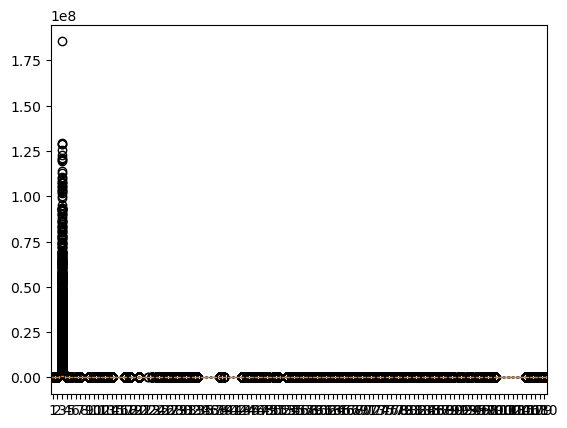

In [65]:
figure=plt.boxplot(numeric_data)

### deal with outliers. Data is too much, our jupyter runs for hours and currupt twice, still cannot finish the code

In [68]:
#require a lot of time to run
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int' or column[1]=='float']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    #reduce是对列column_add做操作
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))
    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df


In [ ]:
from functools import reduce
def find_outliers_optimized(df):
    # Identifying the numerical columns in a Spark DataFrame
    numeric_columns = [column[0] for column in df.dtypes if column[1] == 'int' or column[1] == 'float']

    # Compute summary statistics for all numeric columns
    summary_stats = df.summary("25%", "75%")

    for column in numeric_columns:
        IQR = float(summary_stats.filter(F.col("summary") == "75%").select(column).first()[column]) - \
              float(summary_stats.filter(F.col("summary") == "25%").select(column).first()[column])

        less_Q1 = float(summary_stats.filter(F.col("summary") == "25%").select(column).first()[column]) - 1.5 * IQR
        more_Q3 = float(summary_stats.filter(F.col("summary") == "75%").select(column).first()[column]) + 1.5 * IQR

        isOutlierCol = 'is_outlier_{}'.format(column)

        df = df.withColumn(isOutlierCol, when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new column "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers', reduce(column_add, (df[col] for col in selected_columns)))
    # Dropping the extra columns created above
    df = df.drop(*selected_columns)

    return df

In [66]:
# check if null values exist in numeric features 
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_features]).show(1, vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 value_eur                   | 0   
 wage_eur                    | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_team_id                | 0   
 league_level                | 0   
 club_jersey_number          | 0   
 nationality_id              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control          | 0   
 movement_acceleration       | 0   
 movement_sprint_speed       | 0   
 movement_agility           

In [51]:
# df_with_outlier_handling = find_outliers(df)
# df_with_outlier_handling.groupby("total_outliers").count().orderBy('total_outliers').show()
# df=df_with_outlier_handling

In [52]:
#todo：delete rows with outliers > 4
# df = df.filter(df['total_Outliers']<=4)
# print(df.count())

### Numeric Varibale Distribution

In [54]:
# sb.pairplot(df[numeric_features[:]].toPandas())

### Analyze Correlation of Numerica Features

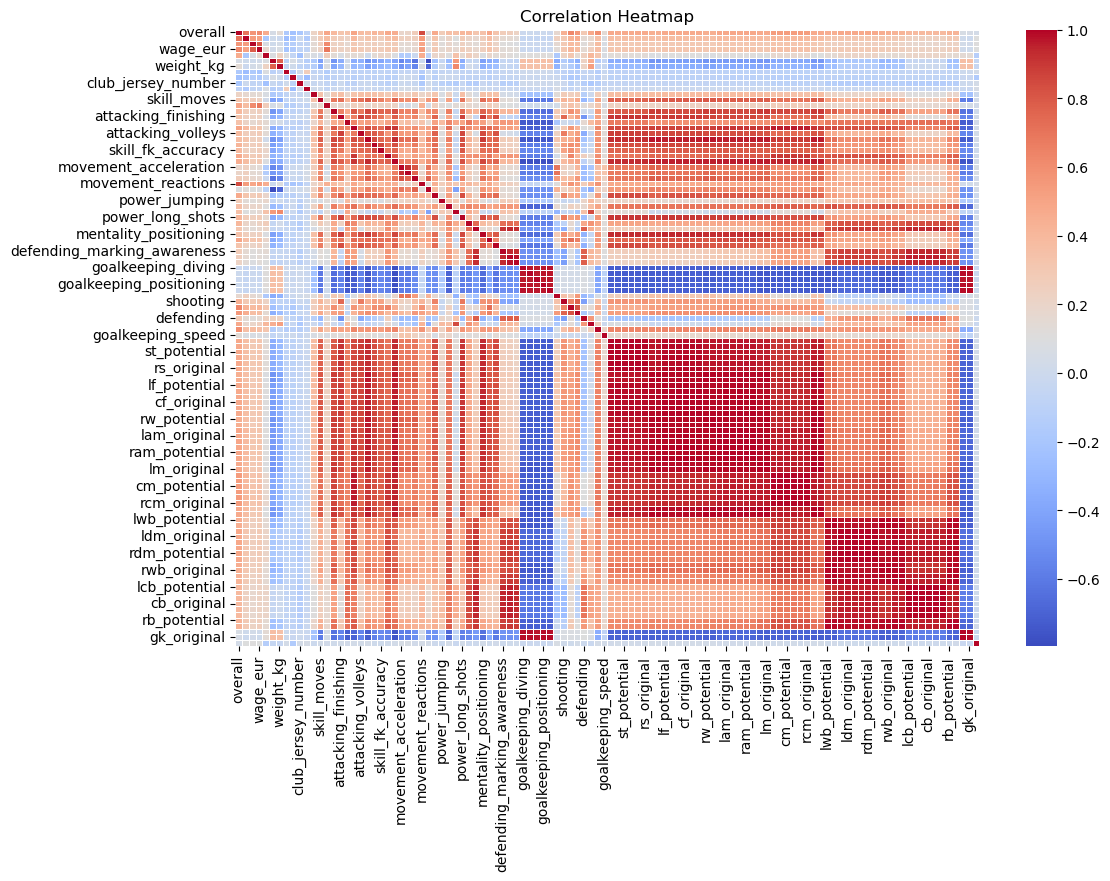

In [66]:
correlation_matrix = df[numeric_features].toPandas().corr()
plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

### Drop highly correlated columns

In [56]:
# numeric_features[-14:-9]

['goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes']   
Even though these 5 columns are highly related, I don't think it's a good idea to drop them.

### We believe that, although lots of columns are highly correlated, such as lm_potential, lm_original, we should not delete them as they have different meaning. so we keep all features here 

## Spark Pipeline

In [67]:
print(category_features)

['player_positions', 'league_name', 'club_position', 'preferred_foot', 'work_rate', 'body_type']


In [13]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ['player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
             'club_team_id', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'nationality_id',
             'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'attacking_crossing',
             'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
             'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
             'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 
             'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
             'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 
             'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
             'goalkeeping_reflexes', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'mentality_composure', 
             'goalkeeping_speed', 'ls_potential', 'ls_original', 'st_potential', 'st_original', 'rs_potential', 'rs_original', 
             'lw_potential', 'lw_original', 'lf_potential', 'lf_original', 'cf_potential', 'cf_original', 'rf_potential', 'rf_original',
             'rw_potential', 'rw_original', 'lam_potential', 'lam_original', 'cam_potential', 'cam_original', 'ram_potential',
             'ram_original', 'lm_potential', 'lm_original', 'lcm_potential', 'lcm_original', 'cm_potential', 'cm_original', 
             'rcm_potential', 'rcm_original', 'rm_potential', 'rm_original', 'lwb_potential', 'lwb_original', 'ldm_potential', 
             'ldm_original', 'cdm_potential', 'cdm_original', 'rdm_potential', 'rdm_original', 'rwb_potential', 'rwb_original', 
             'lb_potential', 'lb_original', 'lcb_potential', 'lcb_original', 'cb_potential', 'cb_original', 'rcb_potential', 'rcb_original',
             'rb_potential', 'rb_original', 'gk_potential', 'gk_original', 'club_contract_valid_last']

#we don't have binary_cols here
nominal_cols = ['player_positions', 'league_name', 'club_position', 'preferred_foot', 'work_rate', 'body_type']

#'value_eur' should not be included, because it's outcome
continuous_cols =['overall', 'potential', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id',
                  'league_level', 'club_jersey_number', 'nationality_id', 'weak_foot', 'skill_moves', 
                  'international_reputation', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                  'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
                  'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                  'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
                  'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision',
                  'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
                  'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes',
                  'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'mentality_composure', 'goalkeeping_speed',
                  'ls_potential', 'ls_original', 'st_potential', 'st_original', 'rs_potential', 'rs_original', 'lw_potential', 
                  'lw_original', 'lf_potential', 'lf_original', 'cf_potential', 'cf_original', 'rf_potential', 'rf_original',
                  'rw_potential', 'rw_original', 'lam_potential', 'lam_original', 'cam_potential', 'cam_original', 'ram_potential',
                  'ram_original', 'lm_potential', 'lm_original', 'lcm_potential', 'lcm_original', 'cm_potential', 'cm_original',
                  'rcm_potential', 'rcm_original', 'rm_potential', 'rm_original', 'lwb_potential', 'lwb_original', 'ldm_potential',
                  'ldm_original', 'cdm_potential', 'cdm_original', 'rdm_potential', 'rdm_original', 'rwb_potential', 'rwb_original',
                  'lb_potential', 'lb_original', 'lcb_potential', 'lcb_original', 'cb_potential', 'cb_original', 'rcb_potential',
                  'rcb_original', 'rb_potential', 'rb_original', 'gk_potential', 'gk_original', 'club_contract_valid_last']

drop1_cols=['dob','club_joined','club_name','nationality_name','player_url','player_face_url','club_logo_url',
            'club_flag_url','nation_logo_url','nation_flag_url','sofifa_id','short_name','long_name','real_face',
            'club_loaned_from','nation_team_id','nation_position','nation_jersey_number',
           'release_clause_eur','player_tags','player_traits']

drop_na_cols=["value_eur",'wage_eur','league_name','league_level',\
                     'club_position','club_jersey_number','club_contract_valid_until']

imputed_cols=['pace','shooting','passing','dribbling','defending','physic','mentality_composure','goalkeeping_speed']

modify_cols=['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm',
                'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb','cb', 'rcb', 'rb', 'gk']


class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df=dataset
        output_df = output_df.withColumn('outcome', col('value_eur').cast(DoubleType())).drop('value_eur')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col in self.columns_to_drop:
            output_df = output_df.drop(col)
        return output_df

class NaDropper(Transformer):
    def __init__(self, columns_to_dropna = None):
        super().__init__()
        self.columns_to_dropna=columns_to_dropna
    def _transform(self, dataset):
        output_df = dataset
        output_df = output_df.na.drop(subset=self.columns_to_dropna)
        return output_df

class Imputation(Transformer):
    def __init__(self, imputed_cols = None):
        super().__init__()
        self.imputed_cols=imputed_cols
    def _transform(self, dataset):
        imputer = Imputer (
                    inputCols=self.imputed_cols,
                    outputCols=["{}_imputed".format(c) for c in self.imputed_cols])\
                    .setStrategy("median").setMissingValue(None)
        output_df = dataset
        output_df = imputer.fit(output_df).transform(output_df)
        for col in self.imputed_cols:
            output_df = output_df.drop(col)
            output_df = output_df.withColumnRenamed("{}_imputed".format(col),col)
        return output_df

class Modifier(Transformer):
    def __init__(self, modify_cols = None):
        super().__init__()
        self.modify_cols=modify_cols
    def _transform(self, dataset):
        output_df = dataset
        for column in self.modify_cols:
            column_potential=f'{column}_potential'
            column_original=f'{column}_original'
            output_df = output_df.withColumn(column_potential, get_potential(col(column)))
            output_df =output_df.withColumn(column_original,get_original(col(column))).drop(column)   
        return output_df



class GetClubContractValidLast(Transformer):
    def __init__(self, modify_cols = None):
        super().__init__()
    def _transform(self, dataset):
        output_df = dataset
        output_df=output_df.withColumn('club_contract_valid_last',col('club_contract_valid_until')-col('year')).drop('club_contract_valid_until').drop('year')
        return output_df
    
def get_preprocess_pipeline():
    
    stage_column_dropper1 = ColumnDropper(columns_to_drop = drop1_cols)
    
    stage_column_dropper2=NaDropper(columns_to_dropna=drop_na_cols)
    
    stage_imputation=Imputation(imputed_cols)
    
    stage_column_modify1=Modifier(modify_cols)
    
    stage_column_modify2=GetClubContractValidLast()
    
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    
    #We need to define handleInvalid
    #Otherwise, after fitting train_df_raw, when we transform test_df_raw, 
    #there will be some labels which never occur in train_df_raw and will cause error
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols,handleInvalid='keep' )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+nominal_onehot_cols
    
#     corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
#                      "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
#     for col_name in corelated_cols_to_remove:
#         feature_cols.remove(col_name)

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper3 = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+  continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_column_dropper1,stage_column_dropper2,stage_imputation,stage_column_modify1,stage_column_modify2,\
                                stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,stage_vector_assembler,
                                stage_scaler,stage_outcome,stage_column_dropper3])
    return pipeline 

In [14]:
df_raw=sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()
df_raw.count()

14134

In [15]:
# split dataset into train,test dataset by order
total_rows = df_raw.count()

split_point = int(total_rows * 0.8)

train_df_raw = df_raw.limit(split_point)
test_df_raw = df_raw.subtract(train_df_raw)

# # 使用randomSplit方法划分train dataset和test dataset
# weights = [0.8,0.2]

# train_df_raw, test_df_raw= train_df_raw.randomSplit(weights, seed=42)
print(train_df_raw.count(),test_df_raw.count())

23/11/12 03:27:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


11307 2827


In [16]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train_df_raw)

train_df = preprocess_pipeline_model.transform(train_df_raw)
test_df = preprocess_pipeline_model.transform(test_df_raw)

In [72]:
pdf=train_df.toPandas()
pdf

,features,outcome
0,"(9.21868909988033, 10.428104878885588, 0.08722...",400000.0
1,"(9.21868909988033, 10.428104878885588, 0.39250...",575000.0
2,"(9.21868909988033, 10.902109646107661, 0.08722...",600000.0
3,"(9.21868909988033, 11.534116002403756, 0.21806...",500000.0
4,"(9.21868909988033, 11.218112824255709, 0.34889...",650000.0
...,...,...
55929,"(10.336105960471885, 11.69211759147778, 0.6541...",3400000.0
55930,"(10.336105960471885, 11.69211759147778, 0.6541...",3400000.0
55931,"(10.336105960471885, 12.00812076962583, 0.8722...",3500000.0
55932,"(10.336105960471885, 12.166122358699853, 0.654...",3600000.0


## Spark Models

### GBT

In [42]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [43]:
gbt = GBTRegressor(featuresCol="features", labelCol="outcome", maxIter=10)

In [44]:
gbt_model = gbt.fit(train_df)

In [45]:
predictions = gbt_model.transform(test_df)

In [46]:
predictions.show(3,vertical=True)

-RECORD 0--------------------------
 features   | (1452,[0,1,2,3,4,... 
 outcome    | 160000.0             
 prediction | 358529.45334771235   
-RECORD 1--------------------------
 features   | (1452,[0,1,2,3,4,... 
 outcome    | 1700000.0            
 prediction | 1816025.3394006111   
-RECORD 2--------------------------
 features   | (1452,[0,1,2,3,4,... 
 outcome    | 1.05E7               
 prediction | 1.3316336144920195E7 
only showing top 3 rows



In [47]:
# evaludate model 
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

890189.7809144307

### Cross validation/Hyper-parameter tunning for GBT

In [79]:
# # It's too slow to do cross validation
# gbt_paramGrid = (ParamGridBuilder()
#              .addGrid(gbt.maxDepth, [5, 10]) # default 5, []
#              .addGrid(gbt.maxIter,[10, 20]) # default 20
#              .build())

In [80]:
# gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_paramGrid, 
#                     evaluator=evaluator, numFolds=3, parallelism=4)
# gbt_cv_model = gbt_cv.fit(train_df)

23/11/12 01:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
23/11/12 01:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1013.6 KiB
23/11/12 01:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
23/11/12 01:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1007.4 KiB
23/11/12 01:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
23/11/12 01:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1009.1 KiB
23/11/12 01:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
23/11/12 01:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1014.7 KiB
23/11/12 01:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1019.4 KiB
23/11/12 01:43:11 WARN DAGScheduler: Broadcasting large task binary with size 1026.1 KiB
23/11/12 01:43:11 WARN DAGScheduler: Broadcasting large task binary with size 1036.4 KiB
23/11/12 01:43:12 WAR

Py4JJavaError: An error occurred while calling o11952.fit.
: org.apache.spark.SparkException: Job 1316 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1195)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1193)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1193)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2940)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2834)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1484)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2834)
	at org.apache.spark.SparkContext.$anonfun$stop$11(SparkContext.scala:2126)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1484)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2126)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2080)
	at org.apache.spark.SparkContext.$anonfun$new$35(SparkContext.scala:678)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:214)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2066)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:515)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:959)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2282)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2301)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2326)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:436)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:56)
	at org.apache.spark.ml.regression.GBTRegressor.$anonfun$train$1(GBTRegressor.scala:190)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.GBTRegressor.train(GBTRegressor.scala:166)
	at org.apache.spark.ml.regression.GBTRegressor.train(GBTRegressor.scala:56)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [48]:
gbt_paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxIter,[10, 20]) # default 20
             .build())
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_paramGrid, 
                    evaluator=evaluator, numFolds=3, parallelism=4)
gbt_cv_model = gbt_cv.fit(train_df)

### After finding best hyper parameter, apply on train and test data to find loss

In [49]:
gbt_cv_prediction_train = gbt_cv_model.transform(train_df)
gbt_cv_prediction_test = gbt_cv_model.transform(test_df)

In [50]:
gbt_cv_rmse_train = evaluator.evaluate(gbt_cv_prediction_train)
gbt_cv_rmse_test = evaluator.evaluate(gbt_cv_prediction_test)
print(f"Train rmse = {gbt_cv_rmse_train}, test rmse = {gbt_cv_rmse_test}")

Train rmse = 1270081.1639386176, test rmse = 844887.1047228812


### Linear Regression

In [51]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="outcome")

In [52]:
lr_model = lr.fit(train_df)
predictions = lr_model.transform(test_df)

23/11/12 02:00:47 WARN Instrumentation: [aee418e7] regParam is zero, which might cause numerical instability and overfitting.
23/11/12 02:00:53 WARN Instrumentation: [aee418e7] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [53]:
rmse = evaluator.evaluate(predictions)
rmse

2134659.277275423

### Cross validation/Hyper-parameter tunning for Linear Regression

In [54]:
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0,0.01, 0.1]) # default 0
             .addGrid(lr.maxIter, [50, 100, 150]) # default 100
             .build())

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=3, parallelism=4)

lr_cv_model = lr_cv.fit(train_df)

23/11/12 02:01:16 WARN Instrumentation: [fce04c8c] regParam is zero, which might cause numerical instability and overfitting.
23/11/12 02:01:16 WARN Instrumentation: [367b892c] regParam is zero, which might cause numerical instability and overfitting.
23/11/12 02:01:16 WARN Instrumentation: [04e2d78c] regParam is zero, which might cause numerical instability and overfitting.
23/11/12 02:01:32 WARN Instrumentation: [367b892c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/11/12 02:01:35 WARN Instrumentation: [fce04c8c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/11/12 02:01:35 WARN Instrumentation: [04e2d78c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/11/12 02:02:13 WARN Instrumentation: [9a658626] regParam is zero, which might cause numerical instability and overfitting.
23/11/12 02:02:13 WARN Instrumentation: [3ff32a8e] regParam is z

### After finding best hyper parameter, apply on train and test data to find loss

In [55]:
lr_cv_prediction_train = lr_cv_model.transform(train_df)
lr_cv_prediction_test = lr_cv_model.transform(test_df)

In [56]:
lr_cv_rmse_train = evaluator.evaluate(lr_cv_prediction_train)
lr_cv_rmse_test = evaluator.evaluate(lr_cv_prediction_test)
print(f"Train rmse = {lr_cv_rmse_train}, test rmse = {lr_cv_rmse_test}")

Train rmse = 3172764.768123253, test rmse = 2170305.874560101


## PyTorch Models

In [17]:
# !pip3 install torch
from torch.utils.data import Dataset,DataLoader
import torch

In [18]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,idx):
        return (self.x[idx],self.y[idx])

In [19]:
x_train=torch.from_numpy(np.array(train_df.toPandas()['features'].values.tolist(),np.float32))
y_train=torch.from_numpy(np.array(train_df.toPandas()['outcome'].values.tolist(),np.float32))

x_test=torch.from_numpy(np.array(test_df.toPandas()['features'].values.tolist(),np.float32))
y_test=torch.from_numpy(np.array(test_df.toPandas()['outcome'].values.tolist(),np.float32))

In [20]:
train_dataset=MyDataset(x_train,y_train)
middle_dataset=MyDataset(x_test,y_test)

generator = torch.Generator().manual_seed(42)
val_dataset,test_dataset=torch.utils.data.random_split(middle_dataset,[0.5,0.5],generator=generator)

## MLP

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim


In [22]:
class mlp(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(input_dim,128),
            nn.Dropout(0.5),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,output_dim)
        )
    def forward(self,x):
        y=self.sequential(x)
        return y

In [23]:
def mlp_train(lr, N_epochs, batch_size):
    mymodel = mlp(x_train.shape[1],1)
    loss_fun=nn.MSELoss()
    optimizer=torch.optim.Adam(mymodel.parameters(),lr=lr)
    adam_batch_loss=[]
    losses=[] 
    val_losses=[]
    best_loss = float("inf")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(N_epochs):
        # train loop
        batch_loss=[]
        for x_batch,y_batch in train_dataloader:
            if torch.cuda.is_available():
                x_batch=x_batch.cuda()
                y_batch=y_batch.cuda()
            y_pred=mymodel(x_batch)
            y_pred=y_pred.view(y_pred.shape[0]) # get rid of 1
            loss=loss_fun(y_pred,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record result
            adam_batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
            batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
            
        # val loop    
        val_batch_loss=[]
        for x_batch,y_batch in val_dataloader:
            if torch.cuda.is_available():
                x_batch=x_batch.cuda()
                y_batch=y_batch.cuda() 
            score_pred=mymodel(x_batch)
            score_pred=score_pred.view(score_pred.shape[0])
            loss=loss_fun(score_pred,y_batch)
            # record result
            val_batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
        
        #post processing
        losses.append(np.mean(np.array(batch_loss)))
        val_losses.append(np.mean(np.array(val_batch_loss)))
        
        #print progress
        print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")
        
        #save best model
        if (np.sqrt(val_losses[-1])<best_loss):
            print("current epoch is the best so far. Saving model...")
            torch.save(mymodel.state_dict(),f'best_model_{lr}_{epoch}_{batch_size}')
            best_loss=np.sqrt(val_losses[-1])

    return losses, val_losses, adam_batch_loss
        

In [24]:
best_model_loss = []
lowest_val_loss = float("inf")
for lr in [0.002, 0.005]:
    for bs in [64, 128]:
        losses, val_losses, adam_batch_loss = mlp_train(lr, 100, bs)
        if np.min(np.array(val_losses)) < lowest_val_loss:
            best_model_loss = [losses, val_losses, adam_batch_loss]
            lowest_val_loss = np.min(np.array(val_losses))
            print(f"best model is from lr = {lr}, batch size = {bs}")

Epoch=0,train_loss=6073261.0,val_loss=2838728.75
current epoch is the best so far. Saving model...
Epoch=1,train_loss=5577592.5,val_loss=2502715.5
current epoch is the best so far. Saving model...
Epoch=2,train_loss=4475434.0,val_loss=2951195.0
Epoch=3,train_loss=3905241.0,val_loss=3077945.0
Epoch=4,train_loss=3655232.75,val_loss=3052211.75
Epoch=5,train_loss=3455947.0,val_loss=2764333.75
Epoch=6,train_loss=3296289.0,val_loss=2969899.0
Epoch=7,train_loss=3181999.75,val_loss=2743619.25
Epoch=8,train_loss=3066670.5,val_loss=2880679.0
Epoch=9,train_loss=2987778.25,val_loss=2443143.0
current epoch is the best so far. Saving model...
Epoch=10,train_loss=2897508.25,val_loss=2497906.25
Epoch=11,train_loss=2876996.5,val_loss=2756629.75
Epoch=12,train_loss=2824843.5,val_loss=2600240.75
Epoch=13,train_loss=2849017.5,val_loss=2635655.0
Epoch=14,train_loss=2759535.0,val_loss=2678630.25
Epoch=15,train_loss=2724844.0,val_loss=3140809.75
Epoch=16,train_loss=2702760.5,val_loss=2732731.0
Epoch=17,train

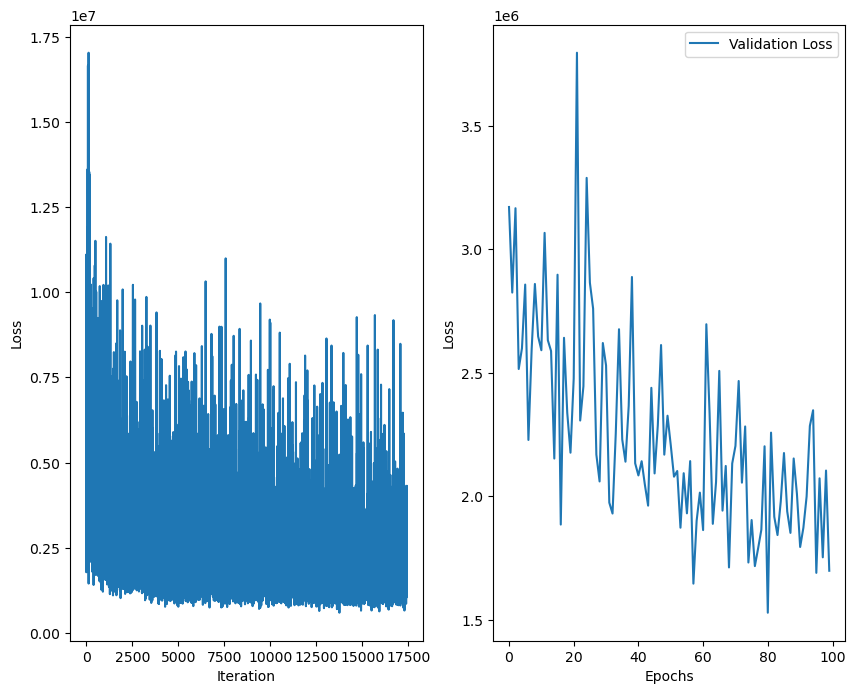

In [25]:
# visualization
N_epochs = 100
fix,axes=plt.subplots(nrows=1,ncols=2,figsize=(10, 8))

axes[0].plot(range(len(best_model_loss[2])),best_model_loss[2],label="adam_batch_loss")
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')

# axes[1].plot(range(N_epochs),best_model_loss[0],label="Train Loss")
# Validation loss is stable here 
axes[1].plot(range(N_epochs),best_model_loss[1],label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

## Load back best model

In [27]:
mybestmodel=mlp(x_train.shape[1],1)

if torch.cuda.is_available():
    mybestmodel=mybestmodel.cuda()

loss_fun=nn.MSELoss()
    
#load best model
mybestmodel.load_state_dict(torch.load("best_model_0.005_80_64"))

#calculate test accuracy
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=True,drop_last=True)
test_batch_loss=[]

for x_batch,y_batch in test_dataloader:
    if torch.cuda.is_available():
        x_batch=x_batch.cuda()
        y_batch=y_batch.cuda()
    y_pred=mybestmodel(x_batch)
    test_batch_loss.append(loss_fun(y_pred,y_batch).detach().cpu().numpy())

test_loss=np.sqrt(np.mean(np.array(test_batch_loss)))
print(f"Test rmse loss ={test_loss}")

Test rmse loss =4324801.0


/opt/conda/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# CNN 

In [67]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(13376, 64)  
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [68]:
def cnn_train(lr, N_epochs, batch_size):
    mymodel = CNN()
    loss_fun=nn.MSELoss()
    optimizer=torch.optim.Adam(mymodel.parameters(),lr=lr)
    adam_batch_loss=[]
    losses=[] 
    val_losses=[]
    best_loss = float("inf")
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(N_epochs):
        # train loop
        batch_loss=[]
        for x_batch,y_batch in train_dataloader:
            if torch.cuda.is_available():
                x_batch=x_batch.cuda()
                y_batch=y_batch.cuda()
            y_pred=mymodel(x_batch.unsqueeze(1))
            y_pred=y_pred.view(y_pred.shape[0]) # get rid of 1
            loss=loss_fun(y_pred,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record result
            adam_batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
            batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
            
        # val loop    
        val_batch_loss=[]
        for x_batch,y_batch in val_dataloader:
            if torch.cuda.is_available():
                x_batch=x_batch.cuda()
                y_batch=y_batch.cuda() 
            score_pred=mymodel(x_batch.unsqueeze(1))
            score_pred=score_pred.view(score_pred.shape[0])
            loss=loss_fun(score_pred,y_batch)
            # record result
            val_batch_loss.append(torch.sqrt(loss).detach().cpu().numpy())
        
        #post processing
        losses.append(np.mean(np.array(batch_loss)))
        val_losses.append(np.mean(np.array(val_batch_loss)))
        
        #print progress
        print(f"Epoch={epoch},train_loss={losses[-1]},val_loss={val_losses[-1]}")
        
        #save best model
        if (np.sqrt(val_losses[-1])<best_loss):
            print("current epoch is the best so far. Saving model...")
            torch.save(mymodel.state_dict(),f'best_model_cnn_{lr}_{epoch}_{batch_size}')
            best_loss=np.sqrt(val_losses[-1])

    return losses, val_losses, adam_batch_loss

In [69]:
best_model_loss_cnn = []
lowest_val_loss_cnn = float("inf")
for lr in [0.0005, 0.001]:
    for bs in [64, 128]:
        losses, val_losses, adam_batch_loss = cnn_train(lr, 10, bs)
        if np.min(np.array(val_losses)) < lowest_val_loss_cnn:
            best_model_loss_cnn = [losses, val_losses, adam_batch_loss]
            lowest_val_loss_cnn = np.min(np.array(val_losses))
            print(f"best model is from lr = {lr}, batch size = {bs}")

Epoch=0,train_loss=6168564.0,val_loss=2937674.0
current epoch is the best so far. Saving model...
Epoch=1,train_loss=6090830.5,val_loss=2881796.25
current epoch is the best so far. Saving model...
Epoch=2,train_loss=6042495.5,val_loss=2868799.0
current epoch is the best so far. Saving model...
Epoch=3,train_loss=6087764.5,val_loss=2779277.75
current epoch is the best so far. Saving model...
Epoch=4,train_loss=5974268.0,val_loss=2663009.0
current epoch is the best so far. Saving model...
Epoch=5,train_loss=5873500.5,val_loss=2698201.0
Epoch=6,train_loss=5734150.5,val_loss=2537634.75
current epoch is the best so far. Saving model...
Epoch=7,train_loss=5605002.5,val_loss=2581474.25
Epoch=8,train_loss=5510676.5,val_loss=2592990.25
Epoch=9,train_loss=5525238.0,val_loss=2811934.5
best model is from lr = 0.0005, batch size = 64
Epoch=0,train_loss=6355323.0,val_loss=3030027.5
current epoch is the best so far. Saving model...
Epoch=1,train_loss=6335112.0,val_loss=2955724.5
current epoch is the 

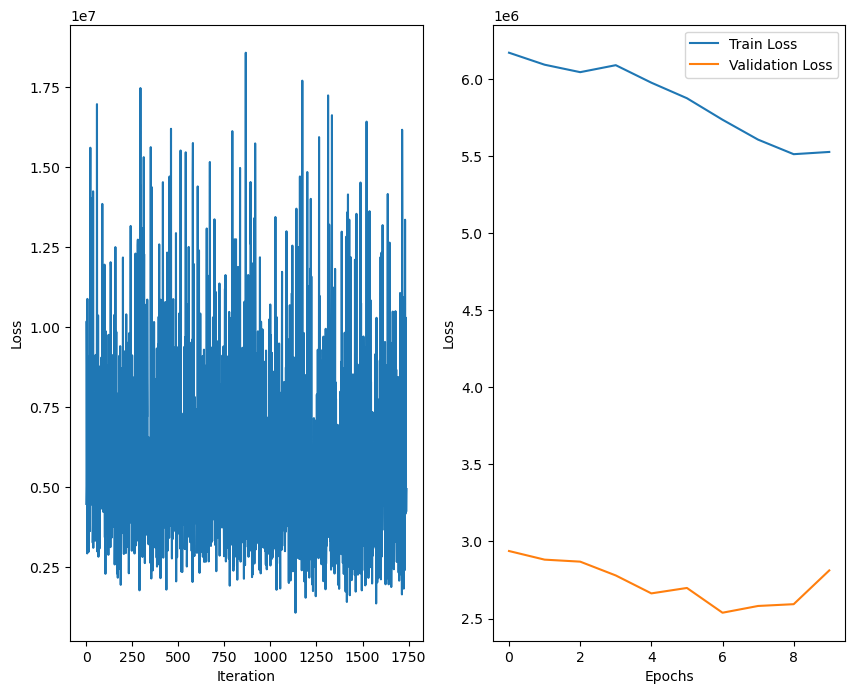

In [70]:
# visualization
N_epochs = 10
fix,axes=plt.subplots(nrows=1,ncols=2,figsize=(10, 8))

axes[0].plot(range(len(best_model_loss_cnn[2])),best_model_loss_cnn[2],label="adam_batch_loss")
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')

axes[1].plot(range(N_epochs),best_model_loss_cnn[0],label="Train Loss")
# Validation loss is stable here 
axes[1].plot(range(N_epochs),best_model_loss_cnn[1],label="Validation Loss")
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [71]:
mybestmodel=CNN()

if torch.cuda.is_available():
    mybestmodel=mybestmodel.cuda()

loss_fun=nn.MSELoss()
    
#load best model
mybestmodel.load_state_dict(torch.load("best_model_cnn_0.0005_6_64"))

#calculate test accuracy
test_dataloader=DataLoader(test_dataset,batch_size=64,shuffle=True,drop_last=True)
test_batch_loss=[]

for x_batch,y_batch in test_dataloader:
    if torch.cuda.is_available():
        x_batch=x_batch.cuda()
        y_batch=y_batch.cuda()
    y_pred=mybestmodel(x_batch.unsqueeze(1))
    test_batch_loss.append(loss_fun(y_pred,y_batch).detach().cpu().numpy())

test_loss=np.sqrt(np.mean(np.array(test_batch_loss)))
print(f"Test rmse loss ={test_loss}")

Test rmse loss =3079566.0


/opt/conda/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
